# Introduction

In this project I will create a multi-class classification supervised learning model to predict product category (prodcat1) a customer is likely to order.

#### Table of content:
1. Data Cleaning
<br>$\;\;\;\;\;\;$ 1.1 Handling null values
<br>$\;\;\;\;\;\;$ 1.2 Handling data types
<br>$\;\;\;\;\;\;$ 1.3 Data filtering
<br>2. EDA
<br>$\;\;\;\;\;\;$ 2.1 prodcat1 observation distribution in order file
<br>$\;\;\;\;\;\;$ 2.2 prodcat1 observation distribution in online file
<br>$\;\;\;\;\;\;$ 2.3 event2 observation distribution in online file
<br>$\;\;\;\;\;\;$ 2.4 total revenue distribution by prodcat1 in order file
<br>$\;\;\;\;\;\;$ 2.5 customers in both files
<br>$\;\;\;\;\;\;$ 2.6 top customers that generate majority of revenue
<br>$\;\;\;\;\;\;$ 2.7 customer segmentation
<br> 3. Feature Engineering
<br> 4. Feature Selection
<br> 5. Modelling
<br>$\;\;\;\;\;\;$ 5.1 Random Forest Classifier
<br>$\;\;\;\;\;\;$ 5.2 SMOTE Random Forest Classifier
<br>$\;\;\;\;\;\;$ 5.3 Gradient Boosting Classifier
<br> 6. Model Comparison
<br> 7. Summary

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
from plotly.offline import iplot
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,accuracy_score,precision_score,recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
import warnings

In [2]:
online_raw = pd.read_csv('online.csv')
online_raw.head(2)

,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1


In [3]:
order_raw = pd.read_csv('order.csv')
order_raw.head(2)

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.3
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.1


# 1.Data Cleaning

### 1.1 Handling null values

In [4]:
order_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263278 entries, 0 to 263277
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   custno     263278 non-null  int64  
 1   ordno      263278 non-null  int64  
 2   orderdate  263278 non-null  object 
 3   prodcat2   261455 non-null  float64
 4   prodcat1   263278 non-null  int64  
 5   revenue    263278 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 12.1+ MB


there are null rows in column prodcat2 in order file. Since these are not lot, I will delete the null rows

In [5]:
order_raw = order_raw.dropna().reset_index(drop=True)

In [6]:
online_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954774 entries, 0 to 954773
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   session   954774 non-null  int64  
 1   visitor   954774 non-null  int64  
 2   dt        954774 non-null  object 
 3   custno    954774 non-null  int64  
 4   category  954774 non-null  int64  
 5   event1    164928 non-null  float64
 6   event2    954774 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 51.0+ MB


lot of missing values in column event1. I will drop this feature from online file

In [7]:
del online_raw['event1']

### 1.2 Handling Data Types

In [8]:
order_raw.dtypes

custno         int64
ordno          int64
orderdate     object
prodcat2     float64
prodcat1       int64
revenue      float64
dtype: object

In [9]:
order_raw['orderdate'] = pd.to_datetime(order_raw['orderdate'])
order_raw = order_raw.rename(columns={'orderdate':'date'})

In [10]:
online_raw.dtypes

session      int64
visitor      int64
dt          object
custno       int64
category     int64
event2       int64
dtype: object

In [11]:
online_raw['dt'] = pd.to_datetime(online_raw['dt'])

'''Changing the name of category to prodcat1'''
online_raw = online_raw.rename(columns={'dt':'date','category':'prodcat1'})

### 1.3 Data Filtering

In [12]:
print('Min date in order file {}'.format(min(order_raw["date"])))
print('Max date in order file {}'.format(max(order_raw["date"])))
print('Min date in online file {}'.format(min(online_raw["date"])))
print('Max date in online file {}'.format(max(online_raw["date"])))

Min date in order file 2016-01-01 05:05:14
Max date in order file 2019-01-02 23:54:58
Min date in online file 2016-01-01 00:00:08
Max date in online file 2017-12-31 23:58:05


the dates are not aligned. I will filter the order data to match online data dates

In [13]:
order_raw = order_raw[order_raw["date"]<=max(online_raw["date"])]

# 2. EDA

### 2.1 prodcat1 observation distribution in order file

c:\users\rr909086\appdata\local\programs\python37_64\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'count of observations in order file by prodcat1')

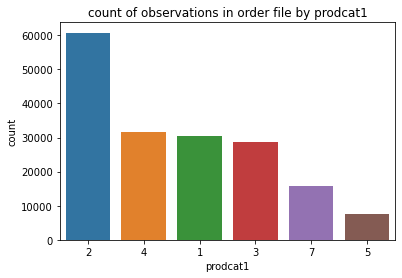

In [14]:
sns.countplot(order_raw['prodcat1'],order = order_raw['prodcat1'].value_counts().index)
plt.title('count of observations in order file by prodcat1')

Takeaway: prodcat1 is our target variable. There are 7 distinct categories. The above distribution shows the data is imbalanced. There are around 60,000 observations for category 2. Category 5 and 7 have very low count of observations. The data need to be resampled for modelling

### 2.2 prodcat1 observation distribution in online file

c:\users\rr909086\appdata\local\programs\python37_64\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'count of observations in online file by prodcat1')

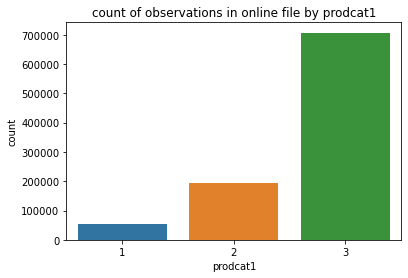

In [15]:
sns.countplot(online_raw['prodcat1'])
plt.title('count of observations in online file by prodcat1')

Takeaway: Online data has only 3 categories (out of 7) and data is incomplete

### 2.3 event2 observation distribution in online file

c:\users\rr909086\appdata\local\programs\python37_64\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'count of observations in online file by event2')

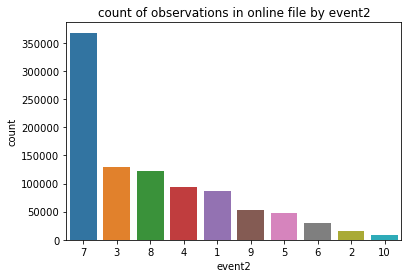

In [16]:
sns.countplot(online_raw['event2'],order = online_raw['event2'].value_counts().index)
plt.title('count of observations in online file by event2')

Takeaway: 10 event2 categories and majority observations fall in category 7

### 2.4 Total revenue distribution by prodcat1 in order file

Text(0.5, 1.0, 'Revenue distribution by prodcat1 in order file')

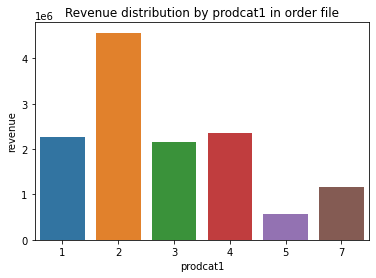

In [17]:
order_cat_groupby = order_raw.groupby(['prodcat1'],as_index=False).agg({'revenue':'sum'})
sns.barplot(x=order_cat_groupby['prodcat1'],y=order_cat_groupby['revenue'])
plt.title('Revenue distribution by prodcat1 in order file')


Takeaway: The revenue distribution by prodcat1 is similar to their observation distribution

### 2.5 Customers in both files

In [18]:
cust_in_order = list(set(order_raw['custno'].tolist()))
print('There are {} unique customers in the order file'.format(len(cust_in_order)))

cust_in_online = list(set(online_raw['custno'].tolist()))
print('There are {} unique customers in the online file'.format(len(cust_in_online)))

count = 0
for i in cust_in_online:
    if i not in cust_in_order:
        count = count+1
        
print('{} customers have online history but no order history'.format(count))

count = 0
for i in cust_in_order:
    if i not in cust_in_online:
        count = count+1
        
print('{} customers have order history but no online history'.format(count))

There are 47169 unique customers in the order file
There are 57584 unique customers in the online file
15082 customers have online history but no order history
4667 customers have order history but no online history


### 2.6 Top customers that generate majority of revenue

In [19]:
order_cust_groupby = order_raw.groupby(['custno'],as_index=False).agg({'revenue':'sum'})
order_cust_groupby = order_cust_groupby.sort_values(['revenue'],ascending=False).reset_index(drop=True)

def abc_classification(df,col,A,B,C):
    df['cumsum'] = df[col].cumsum()                                   
    df['total'] = df[col].sum()                                   
    df['% total']=(df['cumsum']/df['total'])*100                         
    df["classification"] = np.where(df['% total'] <= A, 'A',
                          np.where(df['% total'] <= B,'B', 'C'))   
    return df

order_cust_groupby = abc_classification(order_cust_groupby,'revenue',80,95,100)
order_cust_groupby = order_cust_groupby.groupby(['classification']).size().reset_index()
order_cust_groupby.columns = ['classification','count_customers']
order_cust_groupby

,classification,count_customers
0,A,18000
1,B,15418
2,C,13751


Takeaway: Out of 47,169 customers in order file 18,000 generates 80% of the total revenue i.e. 38% of customers generates 80% revenue

### 2.7 Customer Segementation

For customer segmentation we will create a RFM model. RFM studies customers’ behaviour and cluster them by using three metrics:

<br>1. Recency (R): measure the number of days since the last purchase to a hypothetical snapshot day.
<br>2. Frequency (F): measure the number of transaction made during the period of study
<br>3. Monetary Value (M): measure how much money each customer has spent during the period of study.

In [20]:
present = order_raw['date'].max()+timedelta(days=1)

rfm= order_raw.groupby('custno').agg({'date': lambda date: (present - date.max()).days,
                                        'ordno': lambda num: len(num),
                                        'revenue': lambda price: price.sum()})

rfm.columns = ['recency','frequency','monetary_value']

rfm.describe()

,recency,frequency,monetary_value
count,47169.000000,47169.000000,47169.000000
mean,374.815642,3.698425,277.595358
std,216.152255,9.452336,712.338346
min,1.000000,1.000000,0.010000
25%,194.000000,1.000000,78.440000
50%,338.000000,2.000000,137.230000
75%,575.000000,3.000000,236.590000
max,731.000000,357.000000,24937.040000


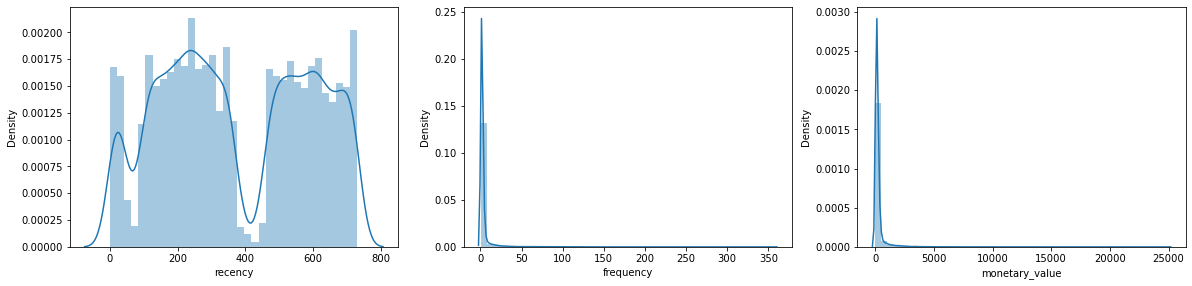

In [21]:
warnings.filterwarnings("ignore")

plt.figure(figsize=(20, 15))
plt.subplot(3, 3, 1)
sns.distplot(rfm['recency'])
plt.subplot(3, 3, 2)
sns.distplot(rfm['frequency'])
plt.subplot(3, 3, 3)
sns.distplot(rfm['monetary_value'])

Takeaway: The distributions of frequency and monetary value are extremely right skewed, especially for frequency. Its min, 25%, 50% and 75% percentile are all close to 1. These tells us customers are purchasing less frequently

Next, we start the log transformation on the RFM dataframe so that the metrics will be put on the same scale.

In [22]:
rfm_log = rfm[['recency', 'frequency', 'monetary_value']].copy()
rfm_log['recency'] = np.log(rfm_log['recency'] )
rfm_log['frequency'] = np.log(rfm_log['frequency'] )
rfm_log['monetary_value'] = np.log(rfm_log['monetary_value'] )

Without standardization, the clustering algorithm could be biased since monetary value might be much higher than the other two variables (recency and frequency are measured in days while monetary value is in dollars term.)

In [23]:
#standardizing the dataset 
scaler = StandardScaler()
scaler.fit(rfm_log)

#store it separately for clustering
rfm_standard = scaler.transform(rfm_log)

#turn the processed data back into a dataframe
rfm_standard = pd.DataFrame(data = rfm_standard, 
                                index = rfm_log.index, 
                                columns = rfm_log.columns) 

We will now fit the data into a clustering algorithm so that the machine could learn patterns from the three metrics and group them accordingly. We will use KMeans algorithm

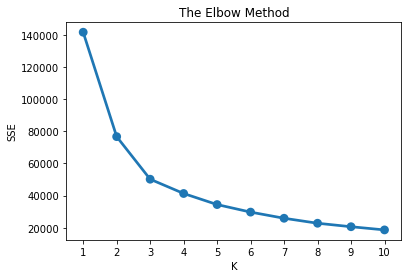

In [24]:
sse = {}
for k in range(1,11):
	kmeans = KMeans(n_clusters = k, random_state=1)
	kmeans.fit(rfm_standard)
	sse[k] = kmeans.inertia_ 

#plot SSE for each K
plt.title('The Elbow Method')
plt.xlabel('K'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show() 

Takeaway: we will use 3 as number of clusters

In [25]:
kmeans = KMeans(n_clusters = 3, random_state=1)

#compute k-means clustering on pre-processed data
kmeans.fit(rfm_standard)

#extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_ 

cust_seg = rfm.assign(KMeanCluster = cluster_labels) 

summary = cust_seg.groupby(['KMeanCluster']).agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary_value':['mean','count']
    })
print(summary) 

                 recency  frequency monetary_value       
                    mean       mean           mean  count
KMeanCluster                                             
0             393.448702   2.897887     227.401572  22808
1              35.421778  23.090516    1731.735544   3701
2             415.043804   1.108325      72.515351  20660


Takeaway: Cluste 1 are our most valued customers, they have shopped 23 times, which is way higher than the other two groups. They shopped 35 days ago, while customers in Cluster 2 shopped 415 days ago. And most importantly, Cluster 1 customers have spent US$1,731

In [27]:
#Attaching clusterid to order data
order_with_cluster = order_raw.join(cust_seg[['KMeanCluster']],on='custno')

# 3. Feature Engineering

We will be creating time based features. The focus will be to avoid data leak i.e not to use any future unknown data. Below are the feature explanation:
<br> note - we choose 35 days since recency for cluster 1 is 35 days
<br> 1. browse_activity_last7days : browsing activity of the customer in last 7 days
<br> 2. max_browse_cat_last7days : max browsed prodcat1 category in last 7 days
<br> 3. max_browse_event_last7days : max browsed event2 category in last 7 days
<br> 4. count_browse_event_last7days : count of unique event2 categories browsed in last 7 days
<br> 5. browse_activity_last35days : browsing activity of the customer in last 35 days
<br> 6. max_browse_cat_last35days : max browsed prodcat1 category in last 35 days
<br> 7. max_browse_event_last35days : max browsed event2 category in last 35 days
<br> 8. count_browse_event_last35days : count of unique event2 categories browsed in last 35 days
<br> 9. order_activity_last7days : total order activity of the customer in last 7 days
<br> 10. count_unique_orders_last7days : count of unique orders in last 7 days
<br> 11. max_prodcat2_type_last7days : max ordered prodcat2 in last 7 days
<br> 12. count_unique_prodcat2_last7days : count of unique prodcat2 categories in last 7 days
<br> 13. total_rev_last7days : total revenue by customer in last 7 days
<br> 14. mean_rev_last7days : mean revenue by customer in last 7 days
<br> 15. order_activity_last35days : total order activity of the customer in last 35 days
<br> 16. count_unique_orders_last35days : count of unique orders in last 35 days
<br> 17. max_prodcat2_type_last35days : max ordered prodcat2 in last 35 days
<br> 12. count_unique_prodcat2_last35days : count of unique prodcat2 categories in last 35 days
<br> 13. total_rev_last35days : total revenue by customer in last 35 days
<br> 14. mean_rev_last35days : mean revenue by customer in last 35 days
<br> 15. day_of_week : numeric day of the week

In [28]:
order_with_cluster1 = order_with_cluster[order_with_cluster["KMeanCluster"]==1].reset_index(drop=True)
order_with_cluster1 = order_with_cluster1.sort_values(by=['custno','date'],ascending = True).reset_index(drop=True)
order_with_cluster1.head()

,custno,ordno,date,prodcat2,prodcat1,revenue,KMeanCluster
0,8,8,2016-06-23 20:28:19,2.0,2,132.19,1
1,8,8,2016-06-23 20:28:19,5.0,2,145.76,1
2,8,8,2016-06-23 20:28:19,35.0,2,138.44,1
3,8,8,2016-06-23 20:28:19,147.0,7,99.12,1
4,8,30964,2016-09-11 18:32:19,172.0,7,135.13,1


In [29]:
def rolling_browsing_history(row,df,d):
  
    endtime = row['date']
    starttime = row['date']-timedelta(days = d)
   
    df_filter = df[(df["custno"]==row["custno"]) & (df["date"]>=starttime) & (df["date"]<=endtime)].reset_index(drop=True)

    if df_filter.shape[0]!=0:
        browse_activity = df_filter.shape[0]
        max_browse_prodcat = df_filter.prodcat1.value_counts().idxmax()  
        max_browse_event = df_filter.event2.value_counts().idxmax() 
        unique_browse_event = df_filter.event2.nunique() 
        
        return pd.Series((browse_activity,max_browse_prodcat,max_browse_event,unique_browse_event))
    else:
        return pd.Series((0,0,0,0))
    

order_with_cluster1[['browse_activity_last7days', 'max_browse_cat_last7days','max_browse_event_last7days','count_browse_event_last7days']] = order_with_cluster1.apply(rolling_browsing_history,df=online_raw,d=7, axis=1)
order_with_cluster1[['browse_activity_last35days', 'max_browse_cat_last35days','max_browse_event_last35days','count_browse_event_last35days']] = order_with_cluster1.apply(rolling_browsing_history,df=online_raw,d=35, axis=1)

def rolling_order_history(row,df,d):
  
    endtime = row['date']
    starttime = row['date']-timedelta(days = d)
   
    df_filter = df[(df["custno"]==row["custno"]) & (df["date"]>=starttime) & (df["date"]<=endtime)].reset_index(drop=True)

    if df_filter.shape[0]!=0:
        order_activity = df_filter.shape[0]
        count_unique_orders = df_filter.ordno.nunique() 
        max_prodcat2_type = df_filter.prodcat2.value_counts().idxmax()  
        count_unique_prodcat2 = df_filter.prodcat2.nunique()
        total_revenue = sum(df_filter.revenue)
        mean_revenue = df_filter.revenue.mean()
        
        return pd.Series((order_activity,count_unique_orders,max_prodcat2_type,count_unique_prodcat2,total_revenue,mean_revenue))
    else:
        return pd.Series((0,0,0,0))

order_with_cluster1[['order_activity_last7days', 'count_unique_orders_last7days','max_prodcat2_type_last7days','count_unique_prodcat2_last7days','total_rev_last7days','mean_rev_last7days']] = order_with_cluster1.apply(rolling_order_history,df=order_raw,d=7, axis=1)
order_with_cluster1[['order_activity_last35days', 'count_unique_orders_last35days','max_prodcat2_type_last35days','count_unique_prodcat2_last35days','total_rev_last35days','mean_rev_last35days']] = order_with_cluster1.apply(rolling_order_history,df=order_raw,d=35, axis=1)

order_with_cluster1['day_of_week'] = order_with_cluster1['date'].dt.dayofweek

In [30]:
order_with_cluster1.head()

,custno,ordno,date,prodcat2,prodcat1,revenue,KMeanCluster,browse_activity_last7days,max_browse_cat_last7days,max_browse_event_last7days,...,count_unique_prodcat2_last7days,total_rev_last7days,mean_rev_last7days,order_activity_last35days,count_unique_orders_last35days,max_prodcat2_type_last35days,count_unique_prodcat2_last35days,total_rev_last35days,mean_rev_last35days,day_of_week
0,8,8,2016-06-23 20:28:19,2.0,2,132.19,1,2,3,4,...,4.0,515.51,128.8775,4.0,1.0,5.0,4.0,515.51,128.8775,3
1,8,8,2016-06-23 20:28:19,5.0,2,145.76,1,2,3,4,...,4.0,515.51,128.8775,4.0,1.0,5.0,4.0,515.51,128.8775,3
2,8,8,2016-06-23 20:28:19,35.0,2,138.44,1,2,3,4,...,4.0,515.51,128.8775,4.0,1.0,5.0,4.0,515.51,128.8775,3
3,8,8,2016-06-23 20:28:19,147.0,7,99.12,1,2,3,4,...,4.0,515.51,128.8775,4.0,1.0,5.0,4.0,515.51,128.8775,3
4,8,30964,2016-09-11 18:32:19,172.0,7,135.13,1,1,3,7,...,1.0,135.13,135.1300,1.0,1.0,172.0,1.0,135.13,135.1300,6


# 4. Feature Selection

Correlation chart

In [31]:
order_with_cluster1.columns


Index(['custno', 'ordno', 'date', 'prodcat2', 'prodcat1', 'revenue',
       'KMeanCluster', 'browse_activity_last7days', 'max_browse_cat_last7days',
       'max_browse_event_last7days', 'count_browse_event_last7days',
       'browse_activity_last35days', 'max_browse_cat_last35days',
       'max_browse_event_last35days', 'count_browse_event_last35days',
       'order_activity_last7days', 'count_unique_orders_last7days',
       'max_prodcat2_type_last7days', 'count_unique_prodcat2_last7days',
       'total_rev_last7days', 'mean_rev_last7days',
       'order_activity_last35days', 'count_unique_orders_last35days',
       'max_prodcat2_type_last35days', 'count_unique_prodcat2_last35days',
       'total_rev_last35days', 'mean_rev_last35days', 'day_of_week'],
      dtype='object')

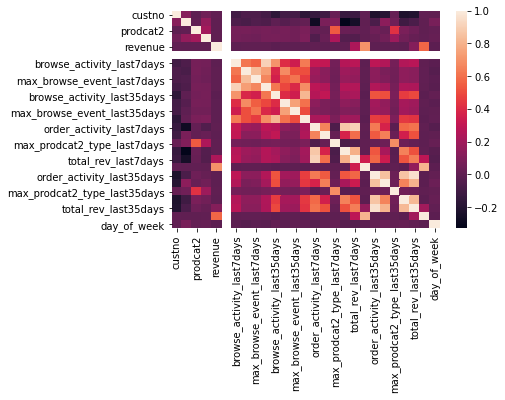

In [32]:
sns.heatmap(order_with_cluster1.corr())

In [33]:
corr_matrix = order_with_cluster1.corr().abs()
corr_matrix

,custno,ordno,prodcat2,prodcat1,revenue,KMeanCluster,browse_activity_last7days,max_browse_cat_last7days,max_browse_event_last7days,count_browse_event_last7days,...,count_unique_prodcat2_last7days,total_rev_last7days,mean_rev_last7days,order_activity_last35days,count_unique_orders_last35days,max_prodcat2_type_last35days,count_unique_prodcat2_last35days,total_rev_last35days,mean_rev_last35days,day_of_week
custno,1.000000,0.126180,0.002448,0.054319,0.003785,NaN,0.092631,0.057978,0.057430,0.086945,...,0.132779,0.115838,0.006474,0.223647,0.193112,0.022000,0.223916,0.211743,0.008239,0.001216
ordno,0.126180,1.000000,0.007044,0.161860,0.000331,NaN,0.057412,0.070050,0.046178,0.057632,...,0.328354,0.247396,0.000693,0.066320,0.141245,0.054801,0.106196,0.064322,0.000977,0.079652
prodcat2,0.002448,0.007044,1.000000,0.210719,0.002367,NaN,0.069466,0.071490,0.065797,0.076370,...,0.031826,0.019539,0.005309,0.047627,0.027049,0.426313,0.083298,0.046071,0.002272,0.017330
prodcat1,0.054319,0.161860,0.210719,1.000000,0.000089,NaN,0.064502,0.055217,0.049786,0.069952,...,0.035737,0.040548,0.000947,0.022270,0.056197,0.186813,0.056422,0.022889,0.004442,0.020183
revenue,0.003785,0.000331,0.002367,0.000089,1.000000,NaN,0.001982,0.001652,0.001477,0.000734,...,0.000677,0.240535,0.702439,0.001967,0.003240,0.002334,0.003312,0.117095,0.570577,0.006873
KMeanCluster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
browse_activity_last7days,0.092631,0.057412,0.069466,0.064502,0.001982,NaN,1.000000,0.617395,0.566220,0.908198,...,0.265645,0.282646,0.003609,0.289456,0.254402,0.067839,0.253709,0.274469,0.000276,0.014498
max_browse_cat_last7days,0.057978,0.070050,0.071490,0.055217,0.001652,NaN,0.617395,1.000000,0.838785,0.735406,...,0.190845,0.175161,0.000028,0.140025,0.086182,0.060661,0.145530,0.133107,0.004608,0.028512
max_browse_event_last7days,0.057430,0.046178,0.065797,0.049786,0.001477,NaN,0.566220,0.838785,1.000000,0.665219,...,0.169981,0.155986,0.001268,0.136653,0.100213,0.055438,0.147322,0.130651,0.004743,0.012228
count_browse_event_last7days,0.086945,0.057632,0.076370,0.069952,0.000734,NaN,0.908198,0.735406,0.665219,1.000000,...,0.261806,0.256462,0.002606,0.255697,0.212880,0.072663,0.243891,0.241873,0.000281,0.017685


Takeaway: 
<br> 1.'max_prodcat2_type_last7days' and 'max_prodcat2_type_last35days' has the largest correlation with prodcat1
<br> 2. 'mean_rev_last7days' and 'mean_rev_last35days' are least correlated with prodcat1 - we will drop these columns

In [34]:
# Find out highly correlated columns

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['total_rev_last35days']

'total_rev_last35days' is highly correlated with 'order_activity_last35days' - we will drop 'total_rev_last35days'

In [35]:
final_selected_features = ['custno', 'ordno','prodcat2','browse_activity_last7days', 'max_browse_cat_last7days',
       'max_browse_event_last7days', 'count_browse_event_last7days',
       'browse_activity_last35days', 'max_browse_cat_last35days',
       'max_browse_event_last35days', 'count_browse_event_last35days',
       'order_activity_last7days', 'count_unique_orders_last7days',
       'max_prodcat2_type_last7days', 'count_unique_prodcat2_last7days',
       'total_rev_last7days','order_activity_last35days',
       'count_unique_orders_last35days', 'max_prodcat2_type_last35days',
       'count_unique_prodcat2_last35days', 'day_of_week']
label = ['prodcat1']

# 5. Modelling

In [36]:
 # Independend variable
X = order_with_cluster1[final_selected_features]

# Depeneded variable
y = order_with_cluster1[label]

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train =np.asarray(y_train)
y_test =np.asarray(y_test)

### 5.1 Random Forest Classifier

In [37]:
rfc=RandomForestClassifier(random_state=42)

In [38]:
param_grid = { 
    'bootstrap': [True],
    'max_depth': [80, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100]
}

In [39]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3, n_jobs = -1, verbose = 2)
CV_rfc.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100]},
             verbose=2)

In [40]:
CV_rfc.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [41]:
rfc1=RandomForestClassifier(random_state=42, max_features=3, n_estimators= 100, max_depth=80, criterion='gini',
                           bootstrap=True,min_samples_leaf=3,min_samples_split=8)
rfc1.fit(X_train, y_train.ravel())
pred = rfc1.predict(X_test)
print("Accuracy for Random Forest: ",accuracy_score(y_test,pred))

Accuracy for Random Forest:  0.8504715977590241


In [42]:
report = classification_report(y_test,pred)
print(report)

              precision    recall  f1-score   support

           1       0.85      0.86      0.86      4958
           2       0.95      0.93      0.94      8463
           3       0.77      0.84      0.80      5549
           4       0.88      0.92      0.90      4229
           5       0.92      0.67      0.78      1747
           7       0.68      0.65      0.66      3256

    accuracy                           0.85     28202
   macro avg       0.84      0.81      0.82     28202
weighted avg       0.85      0.85      0.85     28202



Takeaway: As we know the data is imbalanced and we have more observations for prodcat class 2 and thats why we see a higher recall and f1-score for prodcat class 2. On the other hand due to low observations of 5 and 7, we see low recall and f1-score

### 5.2 SMOTE (Synthetic Minority Over-Sampling Technique) with Random Forest

SMOTE is an over-sampling approach in which the minority class is over-sampled by creating “synthetic” examples rather than by over-sampling with replacement.

In [43]:
smote = SMOTE(sampling_strategy='not majority')

In [44]:
clf = Pipeline(steps=[('sampling', smote),('classifier', rfc1)])

In [45]:
clf.fit(X_train, y_train.ravel())

Pipeline(steps=[('sampling', SMOTE(sampling_strategy='not majority')),
                ('classifier',
                 RandomForestClassifier(max_depth=80, max_features=3,
                                        min_samples_leaf=3, min_samples_split=8,
                                        random_state=42))])

In [46]:
pred = clf.predict(X_test)
print("Accuracy for SMOTE Oversampling - Random Forest: ",accuracy_score(y_test,pred))

Accuracy for SMOTE Oversampling - Random Forest:  0.8578115027303028


In [47]:
report = classification_report(y_test,pred)
print(report)

              precision    recall  f1-score   support

           1       0.86      0.85      0.86      4958
           2       0.97      0.92      0.94      8463
           3       0.82      0.81      0.82      5549
           4       0.88      0.93      0.90      4229
           5       0.89      0.79      0.84      1747
           7       0.64      0.74      0.69      3256

    accuracy                           0.86     28202
   macro avg       0.84      0.84      0.84     28202
weighted avg       0.86      0.86      0.86     28202



Takeaway: By applying oversampling technique the overall accuracy increased. The recall for minority class (5,7) also increased. SMOTE Random Forest perform better 

### 5.3 Gradient Boosting Classifier

In [48]:
gbc = GradientBoostingClassifier()

In [49]:
param_grid = {
    "learning_rate": [0.01, 0.05],
    "min_samples_split": np.linspace( 0.5, 12),
    "min_samples_leaf": np.linspace( 0.5, 12),
    "max_depth":[5,8],
    "n_estimators":[80,100]
    }
clf = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv= 3, n_jobs = -1, verbose = 2)

clf.fit(X_train, y_train.ravel())
print(clf.best_params_)

Fitting 3 folds for each of 20000 candidates, totalling 60000 fits
{'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 0.5, 'min_samples_split': 0.5, 'n_estimators': 80}


In [50]:
gbc1=GradientBoostingClassifier(random_state=42, learning_rate= 0.05, max_depth= 5, min_samples_leaf= 0.5, min_samples_split= 0.5, n_estimators= 80)
gbc1.fit(X_train, y_train.ravel())
pred = gbc1.predict(X_test)
print("Accuracy for Gradient Boosting Classifier: ",accuracy_score(y_test,pred))

Accuracy for Gradient Boosting Classifier:  0.3088788029217786


In [51]:
report = classification_report(y_test,pred)
print(report)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      4958
           2       0.32      0.74      0.45      8463
           3       0.28      0.44      0.34      5549
           4       0.00      0.00      0.00      4229
           5       0.00      0.00      0.00      1747
           7       0.00      0.00      0.00      3256

    accuracy                           0.31     28202
   macro avg       0.10      0.20      0.13     28202
weighted avg       0.15      0.31      0.20     28202



# 6. Model Comparison

| Model | Accuracy | macro average precision | macro average recall	| macro average f1 score |
| --- | ------ | --- | --- | --- |
| Random Forest Classifier | 85.04% | 84% | 81% | 82% |
| SMOTE Random Forest Classifier | 85.78% | 84% | 84% | 84% |
| Gradient Boosting Classifier | 30.88% | 10% | 20% | 13% |

Takeaway: We will choose SMOTE Random Forest Classifier as it performs the best with increased recall and f1 score compared to imbalanced Random Forest model

# 7. Summary 

<b>In this exercise I performed and learned the following </b>:
<br> 1. Our datasets are incomplete and imbalanaced - I tried to handle it by filtering and resampling the data.
<br> 2. I segmented the customers using concepts of recency, frequency and monetary value - There are lot of low buying customers. More than 20,000 customers just buy once in a year. We need different business strategies to handle each cluster
<br>$\;\;\;\;\;\;$ Cluster 1: Improve Retention
<br>$\;\;\;\;\;\;$ Cluster 0,2: Improve Retention + Increase Frequency
<br> 3. I created some timebased features and found out that prodcat2 feature has good correlation with label feature prodcat1. I used correlation matrix to select best features.
<br> 4. After running different classification models and using confusion matrix, we determined that Random Forest with SMOTE resampling technique best suits the data.

<b> Next steps </b>:
<br> 1. Better data collection - A balanced dataset where we have equal distribution across the prodcat1 classes both in order and online file.
<br> 2. Create more features at different time lags to provide more information to the model.
<br> 3. Due to time crunch, I subset the data and used only cluster 1 customers to model. A next version model should be able to handle all cluster customers.
<br> 4. I would like to try more complicated models like Neural Networks to enhance accuracy.
<br> 5. In this project I tried oversampling and in future I would like to look into undersampling techniques as well.